## **D101 Pipeline**

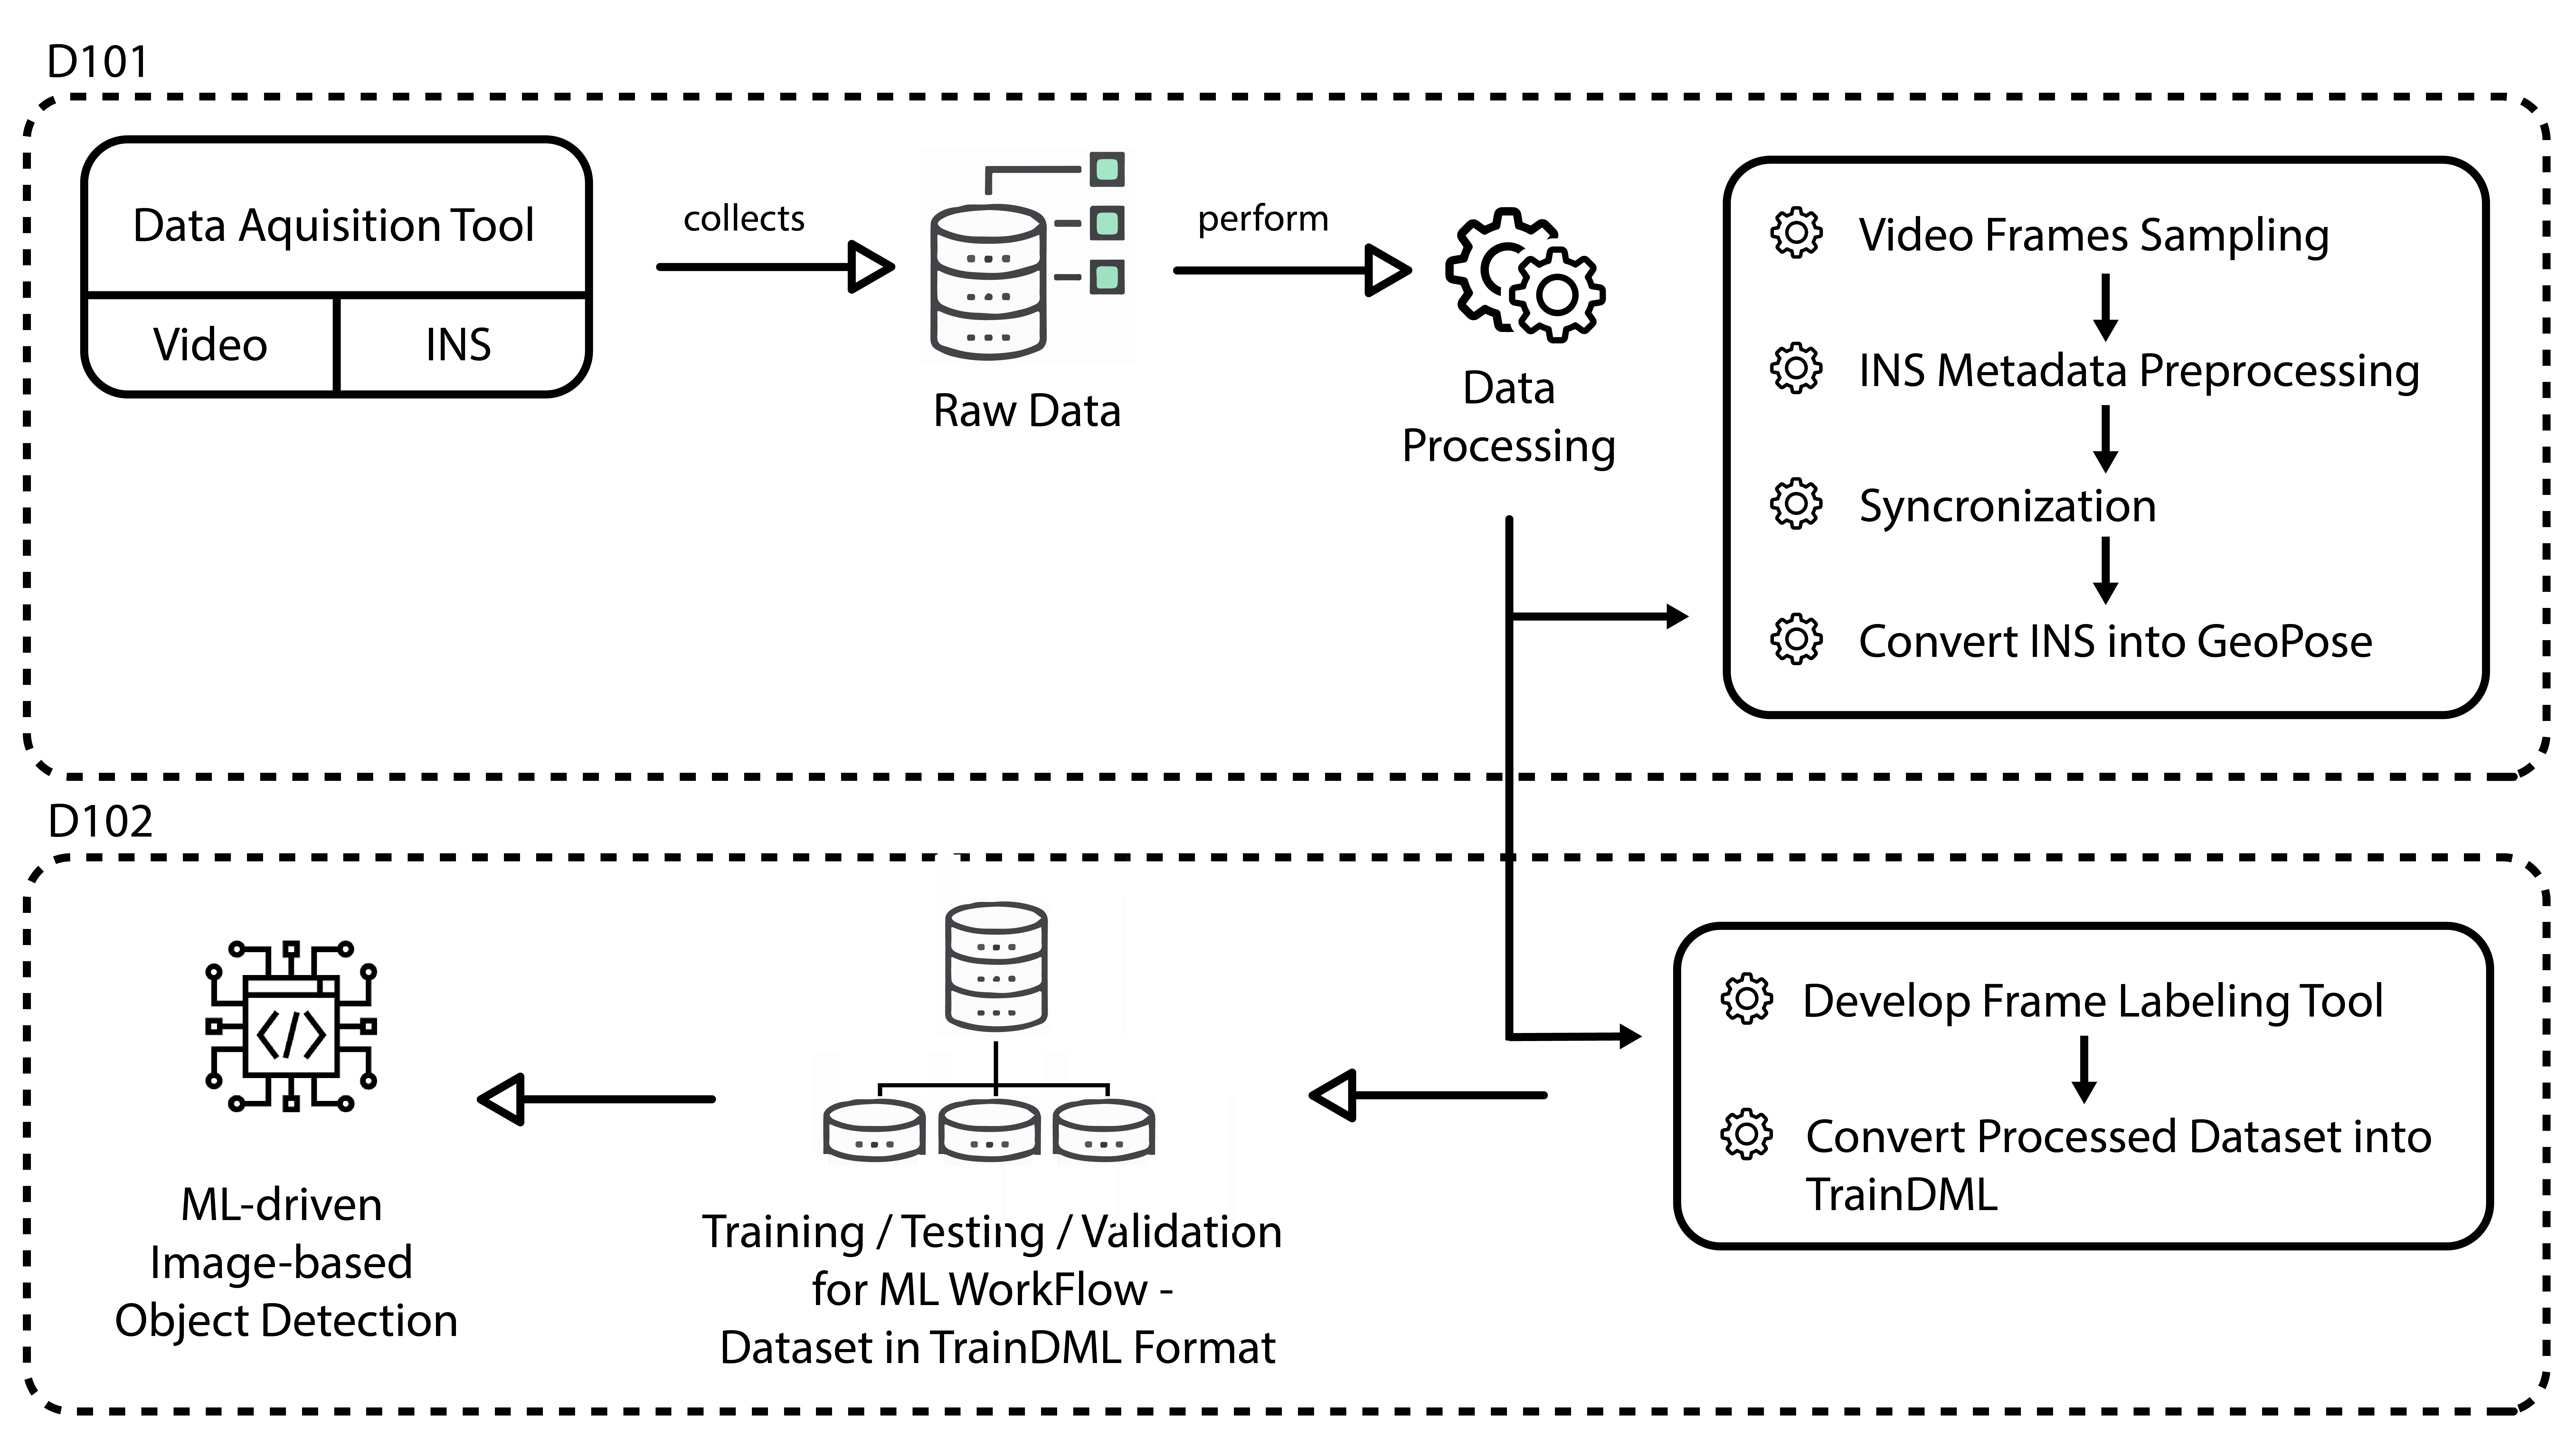

### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import datetime
import os
import shutil
import json
import hashlib

### **Mounting Google Drive For Dataset Access**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Configuration Setup**

### Configuration Setup

The following configuration setup allows for flexibility in defining various acquisition methods, input data sources, and processing options. It is divided into three main sections:

#### 1. **General Configuration Setup**
This section controls the overall data acquisition method and the type of camera imagery being processed:
- **`dataSource`**: Define a custom dataSource variable to streamline parameter tuning and adjustments.
- **`camera_imagery_format`**: Defines the type of camera imagery being processed, either `'image'` or `'video'`. This determines how the camera data is handled.
- **`is_location_orientation_separate_files`**: Boolean which represents if the position and orientation are in same/seperate file. If True, ensure that the `default_time_col` is in the epoch format for efficient mapping and conversion.
- **`is_time_in_gps_format`**: Boolean which defines if the GPS time exists or not. If False, ensure that `df_location_and_orientation` must contain the `date` and `time` columns for conversion

#### 2. **Location & Orientation Configuration Setup**
This section sets up the configuration specific to location and orientation metadata:
- **`url_location`**: Path to the location data CSV file.
- **`url_orientation`**: Path to the orientation data CSV file.
- **`url_location_and_orientation`**: URL to the dataset containing location and orientation metadata (E.g. INS - Inertial Navigation System).

#### 3. **Camera Imaginary Configuration Setup**
- **`url_camera`**: Path to the camera data captured, which includes temporally referenced images.
- **`url_video`**: List of URLs pointing to video files captured from front and rear cameras on the StreetDrone.
- **`url_video_frames_dir`**: Directory path to extracted video frames, if available.
- **`geoReferenced_frames_parent_dir`**: Parent directory containing georeferenced frames.

#### 4. **Common Configuration Setup**
This section handles the configuration of data fields that are common across different datasets:
- **GeoPose Reference Column Names**: The following variables represent the respective column names in the dataset used to extract the **GeoPose** data:
  - **`default_time_col`**: Define the default column name for time data.
  - **`GPS_time_col`**: Column for GPS timestamp.
  - **`lat_col`**, **`lon_col`**, **`alt_col`**: Columns for latitude, longitude, and altitude, respectively.
  - **`qx_col`**, **`qy_col`**, **`qz_col`**, **`qw_col`**: Columns for quaternion values representing orientation.
  - **`yaw_col`**, **`pitch_col`**, **`roll_col`**: Columns for YPR values (Yaw, Pitch, Roll).

- **`orientation_encoding`**: Defines the encoding scheme for the orientation data, either `'angle'` (Yaw, Pitch, Roll) or `'quaternion'`.
- **`YPR_measurements`**: Specifies the measurement unit for YPR (either `'degree'` or `'radian'`).

- **`columns_to_drop`**: List the columns to drop. Use `df.info()` to inspect features, thus identify irrelevant columns.

- **`cameraImaginary_in_sync_df`**: A flag to determine whether a column containing camera image filenames is included in the synchronized DataFrame. Enabling this makes the TrainDML conversion easy.

- **`syncronized_df_parentDir`**: Directory path where the synchronized DataFrame (containing location, orientation, and camera data) will be stored.
- **`geopose_file_name`**: Name of the output GeoPose file.
- **`geopose_file_parentDir`**: Directory where the final GeoPose file will be saved.

This configuration is designed to support both real-time data acquisition via mobile logging and the use of pre-existing datasets like HillyFields, making it adaptable to various project requirements.


In [ ]:
'''
---------------------------------------
General Configuration Setup
---------------------------------------
'''

### Define acquizition method ###
dataSource = 'Sensor Logger' # Define a custom dataSource variable to streamline parameter tuning and adjustments.

# Define Camera Imaginary Type
#   `image`: temporally referenced images
#   `video`: one or multiple raw video(s)
camera_imagery_format = 'image/video'

is_location_orientation_separate_files = None # If True, assuming, `default_time_col` in epoch format for mapping and conversion
is_time_in_gps_format = None # If False, the dataframe of location and orientation must contain the `date` and `time` columns for conversion

'''
---------------------------------------
Configuration Setup
• Depending on Location & Orientation metadata in same/different files
---------------------------------------
'''

# Location & Orientation metadata are in different files
url_location = 'URL_TO_DATASET (Location.csv)'
url_orientation = 'URL_TO_DATASET (Orientation.csv)'

# Location & Orientation metadata within one file
url_location_and_orientation = 'URL_TO_DATASET'


'''
---------------------------------------
Configuration Setup
• Depending on camera imagery format (videos/images)
---------------------------------------
'''

url_camera = 'PATH_TO_DATASET'

url_video = [None] # Enter the path
url_video_frames_dir = [None] # Enter the path
geoReferenced_frames_parent_dir = None # Enter the path (Creates CAM# directory for each video source at this path)

'''
---------------------------------------
Common Configuration Setup
---------------------------------------
'''

# Reference Column Names
default_time_col = None
GPS_time_col = None
lat_col = None
lon_col = None
alt_col = None
qx_col = None
qy_col = None
qz_col = None
qw_col = None
yaw_col = None
pitch_col = None
roll_col = None

# Define encoding scheme for orientation ('angle' | 'quaternion')
orientation_encoding = 'SELECT_ENCODING_SCHEME'
# Define YPR measurement unit ('degree' | 'radian')
YPR_measurements = 'SELECT_UNIT'

# Define the list of columns which could be dropped
columns_to_drop = [] # Use `df.info()` to inspect features, thus identify irrelevant columns

# True: Create a column in syncronized_df containing images filename
# False: Don't create image column in syncronized_df
cameraImaginary_in_sync_df = True

# Define synchronization output path (PATH_TO_FOLDER)
syncronized_df_parentDir = None # Enter the Path

# Define GeoPose output location
geopose_file_name = None # Enter the Name
geopose_file_parentDir = None # Enter the Path

### **Parameter Tuning**

This setup allows for different configurations depending on the data source, so parameters don't need to be manually changed every time.

In [ ]:
# Define DataSource for quick parameter tuning. Quick and easy configuration setup when we know the settings.
dataSource = 'Sensor Logger'

if dataSource == 'Sensor Logger':
  camera_imagery_format = 'image'
  is_location_orientation_separate_files = True # Assuming, `default_time_col` in epoch format
  is_time_in_gps_format = False
  url_location = '/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset/Location.csv' # Data Captured using Sensor Logger
  url_orientation = '/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset/Orientation.csv' # Data Captured using Sensor Logger
  url_camera = '/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset/Camera'
  default_time_col = 'time'
  GPS_time_col = 'GPS time'
  lat_col = 'latitude'
  lon_col = 'longitude'
  alt_col = 'altitude'
  qx_col = 'qx'
  qy_col = 'qy'
  qz_col = 'qz'
  qw_col = 'qw'
  yaw_col = 'yaw'
  pitch_col = 'pitch'
  roll_col = 'roll'
  orientation_encoding = 'quaternion' # Define encoding scheme for orientation ('YPR' | 'quaternion')
  YPR_measurements = 'degree' # Define YPR measurement unit ('degree' | 'radian')
  cameraImaginary_in_sync_df = True # (True) Create a column in syncronized_df containing images filename. (False) Don't create image column in syncronized_df
  syncronized_df_parentDir = f'/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset'
  geopose_file_name = 'GeoPose_SensorLogger_Seq_Series_Regular.json'
  geopose_file_parentDir = f'/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset'

if dataSource == 'HillyFields':
  camera_imagery_format = 'video'
  is_location_orientation_separate_files = False
  is_time_in_gps_format = True
  url_location_and_orientation = 'https://raw.githubusercontent.com/HillyfieldsBubble/Releases/main/SceneGraph/Bubble/StreetDrone/GPS_IMU/STREETDRONE.INS.2023-04-26T133736.000.csv' # StreetDrone INS Dataset for RUN_3
  url_video = ['https://www.google.com/url?q=https%3A%2F%2Fhillyfields.s3.amazonaws.com%2Freleases%2Fscenegraph%2Fbubble%2FStreetDrone%2FCameras%2FFront%2FVideo%2FSTREETDRONE.FRONTCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4',
                'https://www.google.com/url?q=https%3A%2F%2Fhillyfields.s3.amazonaws.com%2Freleases%2Fscenegraph%2Fbubble%2FStreetDrone%2FCameras%2FRear%2FVideo%2FSTREETDRONE.REARCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4']
  url_video_frames_dir = ['/content/drive/MyDrive/Colab Notebooks/Research/OGC/Hillyfield_run3_1s_dataset/FFMPEG/frames_1s/Front',
                          '/content/drive/MyDrive/Colab Notebooks/Research/OGC/Hillyfield_run3_1s_dataset/FFMPEG/frames_1s/Rear']
  geoReferenced_frames_parent_dir = '/content/drive/MyDrive/Colab Notebooks/Research/OGC/Hillyfield_run3_1s_dataset'
  default_time_col = 'Time (GPS µs)'
  GPS_time_col = 'Time (GPS µs)'
  lat_col = 'Latitude (deg)'
  lon_col = 'Longitude (deg)'
  alt_col = 'Altitude (m)'
  qx_col = None
  qy_col = None
  qz_col = None
  qw_col = None
  yaw_col = 'Heading (deg)'
  pitch_col = 'Pitch (deg)'
  roll_col = 'Roll (deg)'
  cols_to_drop = ['UTC offset (s)', 'Position accuracy down (m)', 'Position accuracy east (m)', 'Position accuracy north (m)', 'Heading accuracy (deg)', 'Pitch accuracy (deg)', 'Roll accuracy (deg)', 'Number of GNSS satellites used ()', 'GPS position mode ()', 'GPS velocity mode ()', 'GPS dual antenna attitude mode ()', 'PDOP ()', 'VDOP ()', 'HDOP ()']
  cameraImaginary_in_sync_df = False # (True) Create a column in syncronized_df containing images filename. (False) Don't create image column in syncronized_df
  syncronized_df_parentDir = f'/content/drive/MyDrive/Colab Notebooks/Research/OGC/Hillyfield_run3_1s_dataset/'
  geopose_file_name = 'GeoPose_HillyFields_Seq_Series_Regular.json'
  geopose_file_parentDir = f'/content/drive/MyDrive/Colab Notebooks/Research/OGC/Hillyfield_run3_1s_dataset/'


## **Data Aquisition**

> **Our Approach**

For data acquisition, we utilized the **Sensor Logger** application, available on both the Google Play Store and Apple Store. This application allows for seamless collection of various sensor data from both Android and iOS devices, making it an ideal solution for projects requiring cross-platform compatibility. The Sensor Logger app is open-source and can be found on GitHub: [Sensor Logger GitHub Repository](https://github.com/tszheichoi/awesome-sensor-logger). The detailed unit reference for the sensor data collected, including the measurement units and interpretations, can be accessed here: [Sensor Logger Units Reference](https://github.com/tszheichoi/awesome-sensor-logger/blob/main/UNITS.md).

The data logs contain both raw and calibrated data, providing a comprehensive set of information suitable for post-processing and analysis.

> **Alternative Tools for Data Collection**

As an alternative to the Sensor Logger, the **G-Meter** application is also highly relevant for capturing orientation data. This app specializes in logging data related to gravitational forces and orientation, which can complement or replace the orientation data collected via the Sensor Logger when additional accuracy or different types of orientation analysis are needed.

For camera imaginary along with georeferenced position, **IP Webcam Pro** is an excellent choice for streaming real-time videos or saving recorded videos for later analysis. This app turns the phone into a network camera with multiple video and data streaming options, providing high-quality video recordings that can be synchronized with other sensor data to create a comprehensive dataset for analysis.

> **Existing Available Datasets**

In addition to real-time data collection, we can leverage pre-existing datasets to supplement our data analysis:

1. **HillyFields Bubble Dataset**: Leveraged Run-3 from the dataset with a 5:35-minute duration video caputered from front and rear camera sampled at a frequency of 1 second, offering a detailed real-world dataset that includes both video and associated INS metadata. The dataset is available on GitHub: [HillyFields Bubble Releases](https://github.com/HillyfieldsBubble/Releases).
  *   [StreetDrone Run3 Front CAM](https://hillyfields.s3.amazonaws.com/releases/scenegraph/bubble/StreetDrone/Cameras/Front/Video/STREETDRONE.FRONTCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4)
  *   [StreetDrone Run3 Rear CAM](https://hillyfields.s3.amazonaws.com/releases/scenegraph/bubble/StreetDrone/Cameras/Rear/Video/STREETDRONE.REARCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4)
  *   [StreetDrone Run3 INS Metadata](https://raw.githubusercontent.com/HillyfieldsBubble/Releases/main/SceneGraph/Bubble/StreetDrone/GPS_IMU/STREETDRONE.INS.2023-04-26T133736.000.csv)

2. **KITTI Dataset**: The KITTI dataset is one of the most comprehensive autonomous driving datasets available. It includes over 320,000 images captured over a driving distance of 73.7 km. This dataset can be used for tasks such as object detection, 3D object tracking, and visual odometry, providing a wealth of data for driving-related research. More information about the dataset is available here: [KITTI-360 Dataset](https://www.cvlibs.net/datasets/kitti-360/).

By using these tools and datasets, we ensure a robust and comprehensive approach to data acquisition for our spatial and orientation analysis projects, whether through real-time data logging or utilizing well-established datasets.


## **Raw Dataset**

This section contains the raw non-synchronized data that has been captured using various data acquisition tools or collected from publicly available datasets.

The raw datasets typically include:
- **Location Data**: GPS coordinates (latitude, longitude, altitude) recorded over time.
- **Orientation Data**: Orientation in terms of yaw, pitch, roll, or quaternion values, depending on the sensor and recording method.
- **Camera Data**: Either images or video files captured alongside sensor data, often used for visual analysis or validation purposes.
- **Timestamp**: Timestamp in Epoch, Date-Time format, or GPS time

The data has not yet been synchronized across different modalities (e.g., location, orientation, video), meaning that timestamps between datasets may not match perfectly due to different sampling rates or recording times.

This raw data will serve as the input for further processing steps, such as synchronization, calibration, sampling, and extraction of meaningful features, leading to the generation of GeoPose data or other outputs.

## **Video Frames Sampling**

In this process, we utilized FFMPEG, a popular open-source command-line toolbox, to manipulate, convert, and stream multimedia content. Specifically, FFMPEG was employed for video frame sampling, which involves extracting frames from a video at regular intervals or a predefined frame rate.

FFMPEG: https://www.ffmpeg.org/download.html

**Purpose:**
The goal of this operation is to extract video frames at a specific rate, which can be crucial for tasks like creating training datasets, analyzing video content, or synchronizing with other data sources such as INS metadata.

**Command Syntax:**
The command used in FFMPEG to extract frames is as follows:

> `ffmpeg -i input_video.avi -vf fps=<NO. of images>/<per no. of seconds> img%0<padding No. of digits>d.jpg`

OR

> `ffmpeg -i <input_video> -vf fps=<frames_per_second> <output_pattern>`

* `<input_video>`: The path to the input video file.
* `<frames_per_second>`: The rate at which frames should be extracted. This can be specified as a ratio (e.g., `1/1` for one frame per second).
* `<output_pattern>`: The pattern for naming the output image files. The `%0<padding No. of digits>d` is used to define the format and padding for the output image filenames.

**Example:**
Here is an example command used for frame extraction:

> `ffmpeg -i "C:\Users\OGC\D101\Run3\STREETDRONE.FRONTCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4" -vf fps=1/1 "C:\Users\OGC\D101\Run3\frames\img%04d.png"`

* Input Video: `"C:\Users\OGC\D101\Run3\STREETDRONE.FRONTCAM_VIDEO.2023-04-26T133736.530_obfuscated.mp4"`
* Frame Extraction Rate: 1 frame per second
* Output Pattern: `img%04d.png` (e.g., `img0001.png`, `img0002.png`)

**Exporting Frames into Specific Directories:**
To manage the frames extracted from each video effectively, we can export the frames into separate directories based on the source of the video. This ensures proper organization and allows for easier access during post-processing tasks such as synchronizing with INS metadata.

For example, using the variable `url_video_frames_dir` (a list of directories corresponding to each video), frames from each video can be exported to its respective directory as follows:

```
url_video_frames_dir = [
    "/path_to_directory/CAM1_video_frames/",
    "/path_to_directory/CAM2_video_frames/"
]
```

Each directory in the list `url_video_frames_dir` stores the frames from its respective video source, maintaining a structured approach for handling multiple video streams.

**Outcome:**
The command extracts one frame per second from the input video and saves the frames in the specified directory with sequential numbering.


## **INS Metadata Preprocessing**



### **Defining INS Dataset Path**

In [ ]:
if is_location_orientation_separate_files:
  # Fetch files from the URL and load it into a DataFrame
  df_location = pd.read_csv(url_location)
  df_orientation = pd.read_csv(url_orientation)

if not is_location_orientation_separate_files:
  # Download the INS file (or a file containing location and orientation metadata) from the URL and load it into a DataFrame
  df_location_and_orientation = pd.read_csv(url_location_and_orientation)

### **Epoch to UTC Conversion and Deduplication**

In [ ]:
# Function to convert epoch to yyyy-mm-dd and hh:mm:ss format
def epoch_to_utcDateTime(epoch):
    epoch = str(epoch)
    epoch = epoch[:10]
    epoch = int(epoch)
    return datetime.datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d'), datetime.datetime.utcfromtimestamp(epoch).strftime('%H:%M:%S')

if is_location_orientation_separate_files:
  df_location.rename(columns={default_time_col: 'timestamp'}, inplace=True)
  df_location[['date', 'time']] = df_location['timestamp'].apply(lambda x: pd.Series(epoch_to_utcDateTime(x)))
  df_location = df_location.drop_duplicates(subset=['date', 'time'], keep='first') # Remove duplicate times in df_location, keeping only the first occurrence
  df_orientation.rename(columns={default_time_col: 'timestamp'}, inplace=True)
  df_orientation[['date', 'time']] = df_orientation['timestamp'].apply(lambda x: pd.Series(epoch_to_utcDateTime(x)))
  df_orientation = df_orientation.drop_duplicates(subset=['date', 'time'], keep='first') # Remove duplicate times in df_orientation, keeping only the first occurrence

### **Feature Extraction** - Create Merged and Minified DataFrame

In [ ]:
# Merge Location & Orientation based on Timestamps
if is_location_orientation_separate_files:

  df_location = df_location[['timestamp', 'date', 'time', lat_col, lon_col, alt_col]]

  if orientation_encoding == 'quaternion':
    df_orientation = df_orientation[['timestamp', 'date', 'time', qx_col, qy_col, qz_col, qw_col]]
  elif orientation_encoding == 'angle': # (angle <-> YPR)
    df_orientation = df_orientation[['timestamp', 'date', 'time', yaw_col, pitch_col, roll_col]]
    if YPR_measurements == 'degree':
      df_orientation.loc[:, yaw_col] = df_orientation[yaw_col] * 180 / np.pi
      df_orientation.loc[:, pitch_col] = df_orientation[pitch_col] * 180 / np.pi
      df_orientation.loc[:, roll_col] = df_orientation[roll_col] * 180 / np.pi

  # Merge Position and Orientation Dataframes
  df_location_and_orientation = pd.merge(df_location, df_orientation, on=['date', 'time'], how='inner')

  # Drop the old timestamp columns
  df_location_and_orientation = df_location_and_orientation.drop(columns=['timestamp_x', 'timestamp_y'])

  # Remove rows with any NULL values
  df_location_and_orientation = df_location_and_orientation.dropna()

In [ ]:
# Convert DateTime to GPS_Time format
if not is_time_in_gps_format:

  # Function to convert UTC time to GPS time
  def utc_to_gps(utc_time):
    """
    :param utc_time: A datetime object representing UTC time.
    :return: A datetime object representing GPS time.
    """

    # GPS epoch (January 6, 1980)
    GPS_EPOCH = datetime.datetime(1980, 1, 6, 0, 0, 0)

    # Current leap second difference between GPS and UTC (there is a 18-second difference)
    LEAP_SECONDS = 18

    # Calculate the difference between UTC and GPS epoch
    delta = utc_time - GPS_EPOCH

    # Subtract leap seconds to get GPS time
    gps_time = delta.total_seconds() + LEAP_SECONDS

    return int(gps_time)

  # Function to combine date and time, then convert it to GPS time
  # Assuming that df over which this function is applied must contain individual `date` and `time` columns
  def combine_to_gps_time(row):
    # Combine the date and time into a datetime object
    utc_datetime = datetime.datetime.strptime(f"{row['date']} {row['time']}", '%Y-%m-%d %H:%M:%S')

    # Convert to GPS time using the utc_to_gps function
    gps_time = utc_to_gps(utc_datetime)

    return gps_time

  # Generate GPS time
  df_location_and_orientation[GPS_time_col] = df_location_and_orientation.apply(combine_to_gps_time, axis=1)

  # Move 'GPS Time' to the first column
  cols = df_location_and_orientation.columns.tolist()

  # Remove 'GPS Time' from its original position and insert it at the first position
  cols.insert(0, cols.pop(cols.index(GPS_time_col)))

  # Reorder the DataFrame using the updated column order
  df_location_and_orientation = df_location_and_orientation[cols]

In [ ]:
# Drop irrelevant columns
# Use `df.info()` to inspect features, thus identify irrelevant columns

def drop_columns(df, columns_to_drop):
  df_minified = df.copy()
  df_minified.drop(columns=columns_to_drop, inplace=True, errors='ignore')
  return df_minified

df_location_and_orientation = drop_columns(df_location_and_orientation, columns_to_drop)

In [ ]:
df_location_and_orientation

,GPS time,date,time,latitude,longitude,altitude,qx,qy,qz,qw
0,1410270051,2024-09-13,13:40:33,28.590927,-81.188924,-4.766846,0.357148,0.548101,-0.408990,0.636206
1,1410270052,2024-09-13,13:40:34,28.590927,-81.188924,-4.766846,0.357172,0.548353,-0.408994,0.635973
2,1410270053,2024-09-13,13:40:35,28.590927,-81.188924,-4.721954,0.356874,0.548380,-0.409198,0.635985
3,1410270054,2024-09-13,13:40:36,28.590925,-81.188890,-2.033952,0.356718,0.548438,-0.409203,0.636020
4,1410270055,2024-09-13,13:40:37,28.590925,-81.188890,-2.047449,0.356704,0.548447,-0.409264,0.635981
...,...,...,...,...,...,...,...,...,...,...
1800,1410271859,2024-09-13,14:10:41,28.586542,-81.199147,-2.852920,-0.648498,0.152446,0.726819,0.167166
1801,1410271860,2024-09-13,14:10:42,28.586542,-81.199147,-2.852920,-0.648927,0.152473,0.726377,0.167402
1802,1410271861,2024-09-13,14:10:43,28.586541,-81.199148,-2.480789,-0.649695,0.152759,0.725721,0.167002
1803,1410271862,2024-09-13,14:10:44,28.586541,-81.199148,-2.491013,-0.649763,0.152871,0.725647,0.166959


## **Syncronization**

### **Imaginary from Video**

#### **Defining Video Path**

I've used FFMPEG on local machine for extracting frame samples from the video. There's one another path which specifies the location where frame instances are stored. Note: frames_1s defines a frame rate adjusted to capture frame at every 1-sec of interval.


In [ ]:
if camera_imagery_format == 'video':
  total_video_frames = len([f for f in os.listdir(url_video_frames_dir[0]) if os.path.isfile(os.path.join(url_video_frames_dir[0], f))])

#### **Extracting Relevant INS Samples for Syncronization**

In [ ]:
if camera_imagery_format == 'video':
  def extract_ins_samples(dataset, desired_samples):

    total_samples = len(dataset)

    # Adjusting desired_samples. Remove 0th index at end.
    desired_samples += 1

    # Calculate the interval based on desired number of samples
    interval = max(1, total_samples // desired_samples)

    # Extract samples at the calculated interval
    extracted_samples = dataset.iloc[::interval]

    # Ensure the resulting samples match the desired number
    if len(extracted_samples) > desired_samples:
      extracted_samples = extracted_samples.head(desired_samples)

    # Remove the first row (0th index)
    extracted_samples = extracted_samples.iloc[1:].reset_index(drop=True)

    return extracted_samples

  desired_samples = total_video_frames

  syncronized_df = extract_ins_samples(df_location_and_orientation, desired_samples)

  syncronized_df

#### **Organize Video Frames and INS Data by Instance**

Saving `Video Frames` and respective `Raw INS Information` in organized folder for each imaginary instance (Front/Rear record)

In [ ]:
if camera_imagery_format == 'video':

  os.makedirs(geoReferenced_frames_parent_dir, exist_ok=True)

  # Generate the dictionary with 'CAM%index' as keys and corresponding URLs as values
  imaginary_instance = {f'CAM{index + 1}': url for index, url in enumerate(url_video_frames_dir)}

  for imaginary_instance_name, imaginary_instance_video_frames_dir in imaginary_instance.items():

    for i in range(1, total_video_frames+1):

      # Create a dir: frame_0001, ....
      frame_dir = os.path.join(geoReferenced_frames_parent_dir, f'{imaginary_instance_name}', f'frame_{str(i).zfill(4)}')
      os.makedirs(frame_dir, exist_ok=True)

      # Copy video instance
      shutil.copy(os.path.join(f'{imaginary_instance_video_frames_dir}', f'img{str(i).zfill(4)}.png'), frame_dir)

      # Save INS instance
      with open(os.path.join(frame_dir, f'ins{str(i).zfill(4)}.txt'), 'w') as f:
        f.write(' '.join(map(str, syncronized_df.iloc[i-1])))

### **Imaginary from Temporally referenced Images**

In [ ]:
if camera_imagery_format == 'image':
  # Create a DataFrame from the list of filenames in `Camera` folder
  filenames = [f for f in os.listdir(url_camera) if os.path.isfile(os.path.join(url_camera, f))] # Get a list of filenames
  df_camera = pd.DataFrame(filenames, columns=['timestamp']) # Create a DataFrame from the list of filenames
  df_camera = df_camera.sort_values(by='timestamp') # Sort the DataFrame
  df_camera.reset_index(drop=True, inplace=True) # Reset the index -> cleaning the index column after sorting

  df_camera[['date', 'time']] = df_camera['timestamp'].apply(lambda x: pd.Series(epoch_to_utcDateTime(x)))

  # Retain only the logs for which corresponding images are available by performing an inner join.
  syncronized_df = pd.merge(df_location_and_orientation, df_camera, on=['date', 'time'], how='inner')

  if cameraImaginary_in_sync_df:
    syncronized_df.rename(columns={'timestamp': 'image'}, inplace=True)
  else:
    syncronized_df = syncronized_df.drop(columns=['timestamp'])

In [ ]:
syncronized_df

,GPS time,date,time,latitude,longitude,altitude,qx,qy,qz,qw,image
0,1410270052,2024-09-13,13:40:34,28.590927,-81.188924,-4.766846,0.357172,0.548353,-0.408994,0.635973,1726234834775.jpg
1,1410270053,2024-09-13,13:40:35,28.590927,-81.188924,-4.721954,0.356874,0.548380,-0.409198,0.635985,1726234835738.jpg
2,1410270054,2024-09-13,13:40:36,28.590925,-81.188890,-2.033952,0.356718,0.548438,-0.409203,0.636020,1726234836750.jpg
3,1410270055,2024-09-13,13:40:37,28.590925,-81.188890,-2.047449,0.356704,0.548447,-0.409264,0.635981,1726234837766.jpg
4,1410270056,2024-09-13,13:40:38,28.590925,-81.188890,-2.047449,0.356726,0.548478,-0.409192,0.635988,1726234838753.jpg
...,...,...,...,...,...,...,...,...,...,...,...
1785,1410271859,2024-09-13,14:10:41,28.586542,-81.199147,-2.852920,-0.648498,0.152446,0.726819,0.167166,1726236641859.jpg
1786,1410271860,2024-09-13,14:10:42,28.586542,-81.199147,-2.852920,-0.648927,0.152473,0.726377,0.167402,1726236642857.jpg
1787,1410271861,2024-09-13,14:10:43,28.586541,-81.199148,-2.480789,-0.649695,0.152759,0.725721,0.167002,1726236643874.jpg
1788,1410271862,2024-09-13,14:10:44,28.586541,-81.199148,-2.491013,-0.649763,0.152871,0.725647,0.166959,1726236644860.jpg


### **Store Syncronized DataFrame**

Save Extracted Dataframe for Future Reference or Analysis (Optional)

In [ ]:
def save_dataframe(df, file_path):
    df.to_csv(file_path, index=False)
    print(f"DataFrame saved to {file_path}")

syncronized_df_fullPath = os.path.join(syncronized_df_parentDir, 'syncronized_df.csv')
save_dataframe(syncronized_df, syncronized_df_fullPath)

DataFrame saved to /content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset/syncronized_df.csv


## **Convert INS into GeoPose**

### **Load the INS dataset from Excel**

In [ ]:
# Extracted StreetDrone INS Dataset
ins_df = pd.read_csv(syncronized_df_fullPath)

### **Convert INS Metadata to GeoPose**

Refrences:

- [GeoPose.Composite.Sequence.Series.Regular.Instance](https://github.com/opengeospatial/GeoPose/blob/main/standard/standard/Instances/GeoPose.Composite.Sequence.Series.Regular.Instance.json)

- [GeoPose.Composite.Sequence.Series.Regular.Schema](https://github.com/opengeospatial/GeoPose/blob/main/standard/standard/schemata/GeoPose.Composite.Sequence.Series.Regular.Schema.json)

- [StackOverflow #53408780](https://stackoverflow.com/q/53408780)

- [Matworks geodetic2enu](https://www.mathworks.com/help/map/ref/geodetic2enu.html)

- [GitHub Issues - GeoPose](https://github.com/opengeospatial/GeoPose/issues)

In [ ]:
# Define the reference point (first entry in the dataset)
lat_ref = ins_df.iloc[0][lat_col]
lon_ref = ins_df.iloc[0][lon_col]
alt_ref = ins_df.iloc[0][alt_col]

# Convert the LTP (latitude, longitude, altitude) to ENU for each entry
# enu_coordinates = [
#     geodetic_to_enu(row["Latitude (deg)"], row["Longitude (deg)"], row["Altitude (m)"], lat_ref, lon_ref, alt_ref)
#     for _, row in ins_df.iterrows()
# ]

# Calculate inter-pose duration (assuming regular interval based on GPS time difference)
# NOTE: total_samples = ((last_timestamp - initial_timestamp)/consecutive_timestamp_diff) + 1
timestamps = ins_df[GPS_time_col].values
inter_pose_duration = int(np.median(np.diff(timestamps)))  # Use median to find the regular interval

# Extract the start and stop instants
start_instant = int(str(timestamps[0])[:10])
stop_instant = int(str(timestamps[-1])[:10])

# Count the number of poses
pose_count = len(timestamps)

# Generate a SHA256 integrity check based on the pose data
if orientation_encoding == 'angle':
  pose_data_str = "".join([f"{row[lat_col]}{row[lon_col]}{row[alt_col]}"
                          f"{row[yaw_col]}{row[pitch_col]}{row[roll_col]}" for index, row in ins_df.iterrows()])
elif orientation_encoding == 'quaternion':
  pose_data_str = "".join([f"{row[lat_col]}{row[lon_col]}{row[alt_col]}"
                          f"{row[qx_col]}{row[qy_col]}{row[qz_col]}{row[qw_col]}" for index, row in ins_df.iterrows()])

integrity_check = hashlib.sha256(pose_data_str.encode()).hexdigest()

# Define the outer frame using the reference LTP (Latitude, Longitude, Altitude)
outer_frame = {
    "authority": "/geopose/1.0",
    "id": "LTP-ENU",
    "parameters": f"longitude={lon_ref}&latitude={lat_ref}&height={alt_ref}"
}

# Define the inner frame series (translation and rotation for each pose)
inner_frame_series = []
for i, row in ins_df.iterrows():
    # E, N, U = enu_coordinates[i]
    E, N, U = row[lat_col], row[lon_col], row[alt_col]
    if orientation_encoding == 'angle':
      inner_frame_series.append({
        "authority": "/geopose/1.0",
        "id": "RotateTranslate",
        "parameters": f"translation=[{E}, {N}, {U}]&rotation=[{row[yaw_col]}, {row[pitch_col]}, {row[roll_col]}]"
      })
    elif orientation_encoding == 'quaternion':
      inner_frame_series.append({
        "authority": "/geopose/1.0",
        "id": "RotateTranslate",
        "parameters": f"translation=[{E}, {N}, {U}]&rotation=[{row[qx_col]}, {row[qy_col]}, {row[qz_col]}, {row[qw_col]}]"
      })

# Create the Series Header
series_header = {
    "poseCount": pose_count,
    "integrityCheck": f"{{\"SHA256\": \"{integrity_check}\"}}",
    "startInstant": start_instant,
    "stopInstant": stop_instant,
    "transitionModel": {
        "authority": "/geopose/1.0",
        "id": "none",
        "parameters": ""
    }
}

# Create the Series Trailer
series_trailer = {
    "poseCount": pose_count,
    "integrityCheck": f"{{\"SHA256\": \"{integrity_check}\"}}"
}

# Assemble the GeoPose JSON structure
geopose_series = {
    "header": series_header,
    "interPoseDuration": inter_pose_duration,
    "outerFrame": outer_frame,
    "innerFrameSeries": inner_frame_series,
    "trailer": series_trailer
}

### **Save the GeoPose JSON File**

In [ ]:
geopose_path = os.path.join(geopose_file_parentDir, geopose_file_name)
with open(geopose_path, 'w') as json_file:
    json.dump(geopose_series, json_file, indent=4)

geopose_path

'/content/drive/MyDrive/Colab Notebooks/Research/OGC/MobileLogger/Dataset/GeoPose_SensorLogger_Seq_Series_Regular.json'